In [1]:
# Import packages
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt, calendar
import os
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from scipy.stats import boxcox
import bayes_net_utils as bn

# Introduction

Notebook for generating:

1) A csv of observed seasonal data, just for the variables that are predicted by the Bayesian network, for use when calculating goodness-of-fit statistics of predictions

1) A training data set for the Gaussian Bayesian Network set up for predicting water chemistry and ecology (see notebook Fit_BN). If met data is included as an explanatory variable, then the training data will include met variables. Compared to the observations csv, the training data is truncated to 1981 onwards and the cyanobacteria observations are box cox transformed (this was done within this notebook rather than within the R notebook where the BBN is fit just because I am more familiar with Python than R...).

# User input

Paths to files and folders, and some other settings

In [21]:
# PATHS TO FILES AND FOLDERS

# End year of data available (or desired)
# If including met data (aside from just long term ERA averages), then need to make sure this is
# updated too. Otherwise end dates are 'metno': 2018, 'era5': 2019, 's5':2019
end_year = 2018

start_year = 1980 # Training data is all automatically truncated to 1981.
                  # This only applies for the csv of observations

# Include met data in the observations, training data and evidence data?
include_met = True # True or False

if include_met == True:
    # Met data was used when developing the BBN, but is not used in the operational forecast,
    # and so is not written to csv
    met_source = 'metno' # Choose from 'metno', 'era5'

    # Met (precipitation, wind)
    met_fpath_dict = {'metno': r'../../Data/Meteorological/Obs_metno/Obs_Metno_1km_gridded_Morsa_v2.csv',
                      'era5': r'../../Data/Meteorological/06_era5/era5_morsa_1980-2019_daily.csv'}

    if met_source == 'metno': # Wind is in a separate file
        wind_fpath = r'../../Data/Meteorological/Obs_metno/Obs_Rygge_MeanWindSpeed.csv' # Mean daily wind speed (m/s), Rygge airport
else:
    met_source='nomet'

# Lake water quality
lakewq_fpath = r'../../Data/Observed_Chem_Ecol/Van2_Vanemfjorden_chem_obs.csv'

# Alternative lake colour data (from Storefjorden, 20m depth, MOVAR data)
movar_color_fpath = r'../../Data/Observed_Chem_Ecol/LakeColour_MOVAR.csv'

# Cyanobacteria data
ecol_fpath = r'../../Data/Observed_Chem_Ecol/Van2_Vanemfjorden_Cyanobacteria.csv'

# Output folders
out_file_training = r'../Data/BN_TrainingData/TrainingData_GaussianBN_%s_1981-%s.csv' %(met_source,end_year)

tseries_plot_folder = r'../Figures'
daily_fig_path = os.path.join(tseries_plot_folder,'TrainingData_daily_%s_1981-%s.png' %(met_source,end_year))
sixM_tseries_path = os.path.join(tseries_plot_folder, 'TrainingData_GBN_%s_1981-%s_blackwhite.png' %(met_source,end_year))

out_file_obs = r'../Data/DataMatrices/Seasonal_BN_obs/seasonal_obs_GBN_%s-%s.csv' %(start_year, end_year)


# Read in daily data

In [3]:
if include_met == True:
    # Read in met data
    met_fpath = met_fpath_dict[met_source]

    if met_source=='metno':
        met_df = pd.read_csv(met_fpath, index_col=0, parse_dates=True, dayfirst=True)
        wind_df = pd.read_csv(wind_fpath, index_col=0, parse_dates=True, dayfirst=True)
        met_df = met_df[['RR_catch']] # For now, pick rainfall averaged over whole catchment, not just the lake
        met_df.columns = ['rain']
        met_df.index.name = 'Date'
        met_df.index = met_df.index.normalize() # Drop time info from metdf index
        # Add mean daily wind speed (m/s)
        met_df['wind_speed'] = wind_df.iloc[:,0]    

    else:
        met_df = bn.read_era5_csv(met_fpath) # Read in, calculate wind and reformat

    # Reset any negative values to 0
    met_df.loc[met_df['rain']<0.,'rain'] = 0.

met_df.head()

,rain,wind_speed
Date,,
1970-12-31,0.000000,4.6
1971-01-01,0.000000,0.2
1971-01-02,0.000000,0.3
1971-01-03,0.000000,6.0
1971-01-04,0.000096,2.2


In [4]:
# Lake chem data and chl-a

# Routine monitoring data
lakewq_df = pd.read_csv(lakewq_fpath, index_col=0, parse_dates=True, dayfirst=True)

# Movar colour data for historic period
color_df = pd.read_csv(movar_color_fpath, index_col=0, parse_dates=True, dayfirst=True)

# Process Lake colour data: merge MOVAR and NIVA data.
# Before Jan 1999: NIVA data. Jan 1999- end 2012: Movar data. From Jan 2013: NIVA data

lakewq_df = pd.merge(lakewq_df, color_df, left_index=True, right_index=True, how='outer')

lakewq_df.rename({'colour':'colour_NIVA',
                 'Colour':'colour_Movar'},inplace=True, axis=1)

# Before Jan 1999: NIVA data, Jan 1999- end 2012: Movar data, from Jan 2013: NIVA data
s0 = lakewq_df.loc[:'1998-12-31','colour_NIVA']
id1 = lakewq_df['colour_Movar'].first_valid_index()
s1 = lakewq_df['colour_Movar'].loc[id1:]
lastidx = lakewq_df.loc['2013-01-01':,'colour_NIVA'].last_valid_index()
s2 = lakewq_df.loc['2013-01-01':lastidx,'colour_NIVA']
colour = pd.concat([s0, s1,s2], axis=0).dropna()
colour.name = 'colour'

# Drop original MOVAR and NIVA colour series, and replace with the patched series
lakewq_df = lakewq_df.drop(['colour_NIVA','colour_Movar'], axis=1)
lakewq_df = lakewq_df.merge(colour.to_frame(), left_index=True, right_index=True, how='outer')

# Drop some dodgy-looking values
lakewq_df.loc[:'1982-08-01','colour'] = np.NaN

lakewq_df.tail()

,chl-a,TP,colour
Date,,,
2020-08-10,28.0,20.0,52.0
2020-08-24,13.0,28.0,NaN
2020-09-07,13.0,17.0,47.0
2020-09-21,7.9,17.0,NaN
2020-10-05,6.0,44.0,43.0


In [5]:
# Ecol count data

ecol_df = pd.read_csv(ecol_fpath, index_col=0, parse_dates=True, dayfirst=True)
# convert units to mm3/l (mg/l if assume density is same as water)
ecol_df['Cyano_biovol_mm3_per_l'] = ecol_df['Cyano_biovol_mm3_per_m3']/1000.
ecol_df.drop(['Cyano_biovol_mm3_per_m3'], axis=1, inplace=True)
ecol_df.head()

,Cyano_biovol_mm3_per_l
Date,
1996-06-13,0.12
1996-07-01,1.83
1996-07-22,4.42
1996-08-12,4.23
1996-09-03,4.80


# Merge and visualise daily data

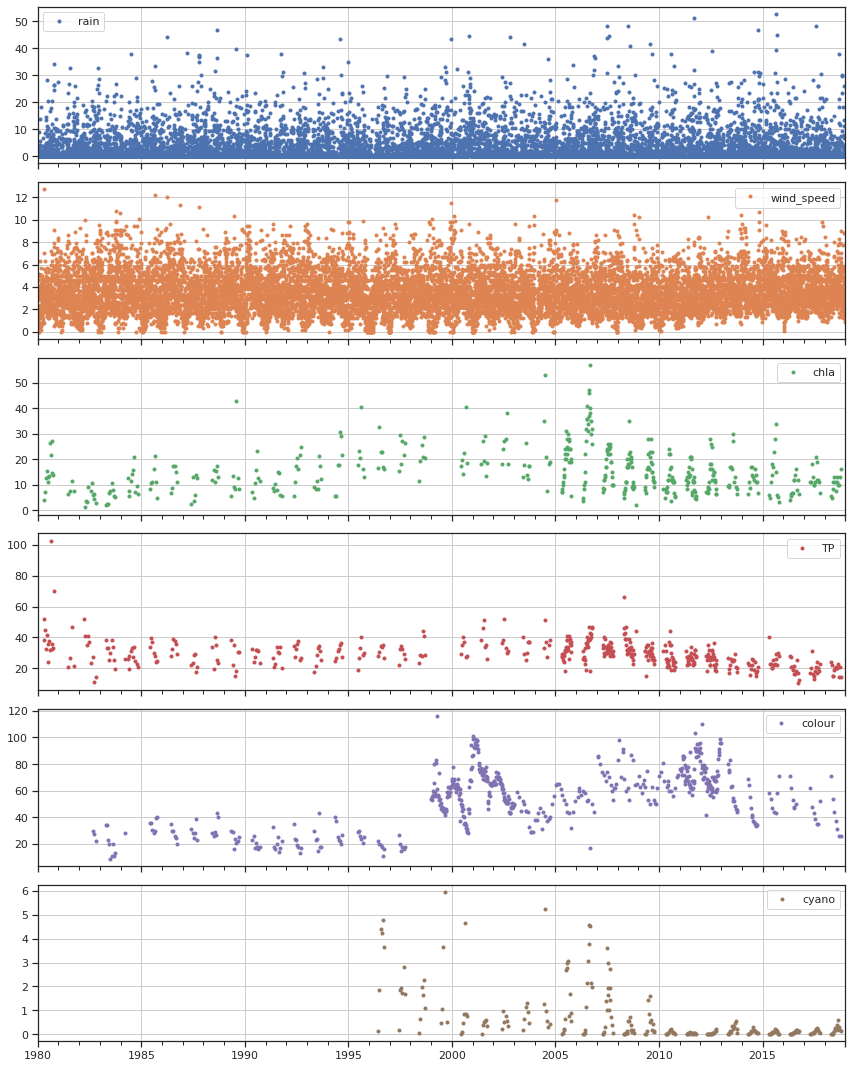

In [6]:
# REINDEX & JOIN ALL DATASETS INTO ONE DATAFRAME

if include_met == True:
    df_list = [met_df, lakewq_df, ecol_df]
else:
    df_list = [lakewq_df, ecol_df]

for i, df in enumerate(df_list):
    df = df.reindex(index=pd.date_range(start='1/1/%s'%start_year, end='31/12/%s'%end_year))
    if i<1:
        daily_df = df
    else:
        daily_df = daily_df.join(df)

# Remove data pre-1980
daily_df = daily_df.loc['1980-01-01':,:]

# Rename some cols
var_rename_dict = {'Biovolume_mm3_per_l':'Biovolume',
                   'Cyano_biovol_mm3_per_l':'cyano',
                   'chl-a':'chla'}
daily_df.rename(var_rename_dict, axis=1, inplace=True)

cols_to_keep = ['TP','chla','colour','cyano',
               'rain','wind_speed']

for col in daily_df.columns:
    if col not in cols_to_keep:
        daily_df.drop(col, axis=1, inplace=True)

# Check output
daily_df.head()

daily_fig = daily_df.loc['1980-01-01':,:].plot(subplots=True, style='o', ms=3,
                                               figsize=(12,15), grid=True);
plt.tight_layout()
plt.savefig(daily_fig_path)

# Resample to seasonal and add previous summer's values

Define two seasons per year. Lake sampling is from mid-April to mid-October, WFD status calculated as the average or maximum observed over the growing season, defined as May-Oct. So use WFD-based season definition of 'summer' vs 'winter'.

The main predictor variables are the values from the previous summer, so add these to the matrix.

In [7]:
summer_df = bn.daily_to_summer_season(daily_df)
       
# Add previous summer values for selected cols
prevSummerCols = summer_df[['colour','TP','chla']].shift(+1)
prevSummerCols = prevSummerCols.add_suffix('_prevSummer')
summer_df = summer_df.join(prevSummerCols)

# Truncate start and end years so covers period 1980/1-end year (incl.)
summer_df = summer_df.loc[start_year:end_year,:]

summer_df.tail()

,rain,colour,TP,chla,wind_speed,cyano,colour_prevSummer,TP_prevSummer,chla_prevSummer
year,,,,,,,,,
2014,633.603979,41.863636,20.300000,12.600000,3.508840,0.283,60.223077,22.992308,14.138462
2015,684.936515,52.833333,24.250000,14.925000,3.769022,0.233,41.863636,20.300000,12.600000
2016,396.823713,52.000000,18.750000,9.590909,3.751630,0.166,52.833333,24.250000,14.925000
2017,570.221295,42.000000,19.666667,12.866667,3.705435,0.258,52.000000,18.750000,9.590909
2018,300.208553,36.333333,18.666667,10.741667,3.959783,0.614,42.000000,19.666667,12.866667


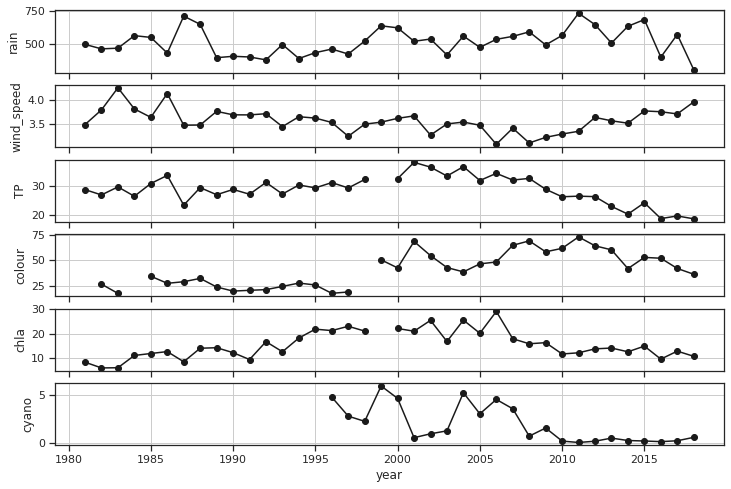

In [22]:
# Quick check of output
if include_met == True:
    vars_to_plot = ["rain", "wind_speed", "TP", "colour", "chla", "cyano"]
else:
    vars_to_plot = ["TP", "colour", "chla", "cyano"]
ax = summer_df[vars_to_plot].plot(
    subplots=True, figsize=(12, 8), grid=True, marker="o", legend=False, color='k'
)
for i in range(len(vars_to_plot)):
    ax[i].xaxis.grid(True, which="minor", linestyle="-", linewidth=0.5)
    ax[i].set_ylabel(vars_to_plot[i])

plt.savefig(sixM_tseries_path)

In [9]:
# Transform cyano data using boxcox transformation to make ~Gaussian
summer_df_bxcx = summer_df.copy()
for col in ['cyano']:
    summer_df_bxcx[col] = boxcox(summer_df_bxcx[col].values, lmbda=0.1)

In [10]:
# Write to csv

# Observations
summer_df[['TP','chla','colour','cyano']].to_csv(out_file_obs)

# Training data. First clip off 1980 if present
summer_df = summer_df.loc[1981:,:]
summer_df_bxcx.to_csv(out_file_training)

In [11]:
# Quick check of normality for GBN (add-on analysis)
from scipy import stats

for var in summer_df_bxcx.columns:
    print("Variable: %s" %var)
    x = summer_df_bxcx[var].dropna().values
    k2, p = stats.normaltest(x)
    alpha = 0.001
    print("p(H0) = %s" %p)
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected, x is not normal")
    else:
        print("No evidence to reject the null hypothesis, x is probably normal")

Variable: rain
p(H0) = 0.695593022685765
No evidence to reject the null hypothesis, x is probably normal
Variable: colour
p(H0) = 0.027242919414798956
No evidence to reject the null hypothesis, x is probably normal
Variable: TP
p(H0) = 0.6444000032595905
No evidence to reject the null hypothesis, x is probably normal
Variable: chla
p(H0) = 0.4221052219707332
No evidence to reject the null hypothesis, x is probably normal
Variable: wind_speed
p(H0) = 0.20431983561952036
No evidence to reject the null hypothesis, x is probably normal
Variable: cyano
p(H0) = 0.03828060668535506
No evidence to reject the null hypothesis, x is probably normal
Variable: colour_prevSummer
p(H0) = 0.016839043568536383
No evidence to reject the null hypothesis, x is probably normal
Variable: TP_prevSummer
p(H0) = 0.48224430417754605
No evidence to reject the null hypothesis, x is probably normal
Variable: chla_prevSummer
p(H0) = 0.49322673055527433
No evidence to reject the null hypothesis, x is probably normal